## CRISM Image Preprocessing

1. Download CRISM data and preprocess in CAT ENVI

	1. Download TRDR data and checkbox that says 'Download DDR' too
	2. Open TRDR images as CAT images in ENVI and save Z profile info for pixel.
	3. For each TRDR and DDR image, do Cat > Convert Format: PDS to CAT
	4. TRDR Data Cleaning
		a. Volcano Scan Correction (in CAT ENVI)  for l file 
			i.  CAT > ATP Corrections >  Division by scaled volcano observation - Empirically optimized for this observation
			ii. Basically removes the CO2 feature at 2 microns. Only for l file because I get errors for s file saying it won't do corrections for s file 


2. Set file names: what CRISM file do you want to preprocess?

In [29]:
import pickle
import pandas as pd
import numpy as np
import spectral.io.envi as envi
from utils.constants import *
from preprocessing.CRISM_preprocess_helpers import *

img_dir = "/Users/marina/mars_data/TRDR10628/processed/"

l_img_name = "frt00010628_07_if165l_trr3"

s_img_name = "frt00010628_07_if165s_trr3"

d_img_name = "frt00010628_07_de165s_ddr1"


CUR_IMG = "frt00010628"

CRISM_DIR = PREPROCESSED_DATA + "CRISM/" 


4. Pull down files (DDR, S, L) and layer S and L.

For frt00010628_07, do special case of dropping last band in L image, it is null. Below, we pull in the CRISM data, clip the borders,  replace null values with 0, and layer L and S images. We also save the CRISM wavelengths to a file in the PREPROCESSED_DATA/CRISM directory, CRISM_wavelengths.pickle

In [17]:
ddr_img, s_img, l_img = get_images(img_dir, d_img_name, s_img_name, l_img_name)

# Special case: Last wavelength of l I/F CRISM img has a wavelength value of null, 
# 65535, so I drop it

l_img =  l_img[:,:,:-1]


#  Layer L and S images. 
pixel_dir = img_dir
img_save_name = "frt00010628"

layer_CRISM(s_img, l_img, pixel_dir, img_save_name)

#  Save angular image
with open(DATA_DIR + "PREPROCESSED_DATA/CRISM/" + img_save_name + "_angles.pickle", 'wb') as f:
    pickle.dump(ddr_img, f)

Reduce image size to row range:0-450 and col range: 25-626
Original range, row max= 450, col max=640


5. Preprocess USGS

Process endmembers. Remove values for which we are missing reflectances (first and last 9 values) from each endmember. Save wavelengths and reflectances as pickles.

In [ ]:
# For each USGS endmember the first and last 10 values are clipped because they are null.
#  Each endmember has the same wavelengths.
#  Each endmember's reflectance is saved in PREPROCESSED_DATA/R
#  The USGS wavelengths are saved in PREPROCESSED_DATA/USGS_wavelengths.pickle
import os
from preprocessing.USGS_preprocessing_helpers import preprocess_USGS
if not os.path.exists(PREPROCESSED_DATA + "USGS_wavelengths.pickle"):
    preprocess_USGS()

6. Reduced wavelengths: RW_CRISM and RW_USGS.

CRISM data has a certain wavelengths, and USGS has different ones. So, we need to find the mutually compatible set. This is what reducing wavelengths is.

When running the model, it will use these reduced wavelengths for the CRISM data and USGS endmembers. Saved in PREPROCESSED_DATA/CRISM as RW_USGS.pickle and RW_CRISM.pickle, which stands for reduced wavelengths. We also have CRISM_wavelengths.pickle there, which is the original, entire set of wavelengths for the CRISM image.

In [ ]:
CRISM_reduced, USGS_reduced = record_CRISM_USGS_reduced_wavelengths()

7. Calculate the optical constant k, the imaginary index of refraction, for each endmember (in each wavelength) 

Recommended to run this on the server/HPC because it takes a while (and can use many threads to infer k in different wavelengths at the same time).

In [ ]:
from preprocessing.estimatek import estimate_all_USGS_k
# CRISM_match = True -> Important. Because we want to calculate k for each
# reduced wavelength (the mutual set between USGS and CRISM)  
estimate_all_USGS_k(CRISM_match = True)

## IN PROGRESS
8. Initialize Angles for CRISM

In [27]:
pixX = 20
pixY = 30
pix = ddr_img[pixX,pixY]
print("Solar incidence angle relative to areoid " + str(pix[0]))
print("Solar incidence angle relative to planetary surface " + str(pix[5]))


print("\nEmission angle relative to areoid " + str(pix[1]))
print("Emission angle relative to planetary surface " + str(pix[6]))


print("\nSolar phase angle " + str(pix[2])) 

Solar incidence angle relative to areoid 57.241676
Solar incidence angle relative to planetary surface 56.951622

Emission angle relative to areoid 33.168503
Emission angle relative to planetary surface 33.693363

Solar phase angle 68.2467


Visualizations below

/Users/marina/Documents/PhD/research/mars_research/code/environments/spec_env/lib/python3.9/site-packages/spectral/graphics/spypylab.py:58: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''


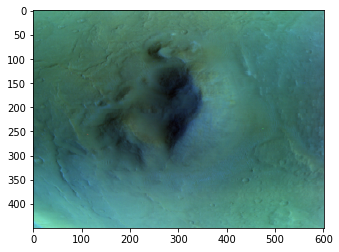

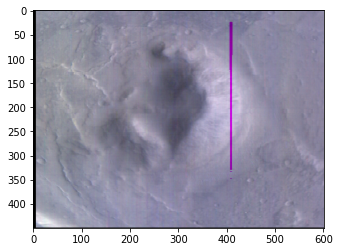

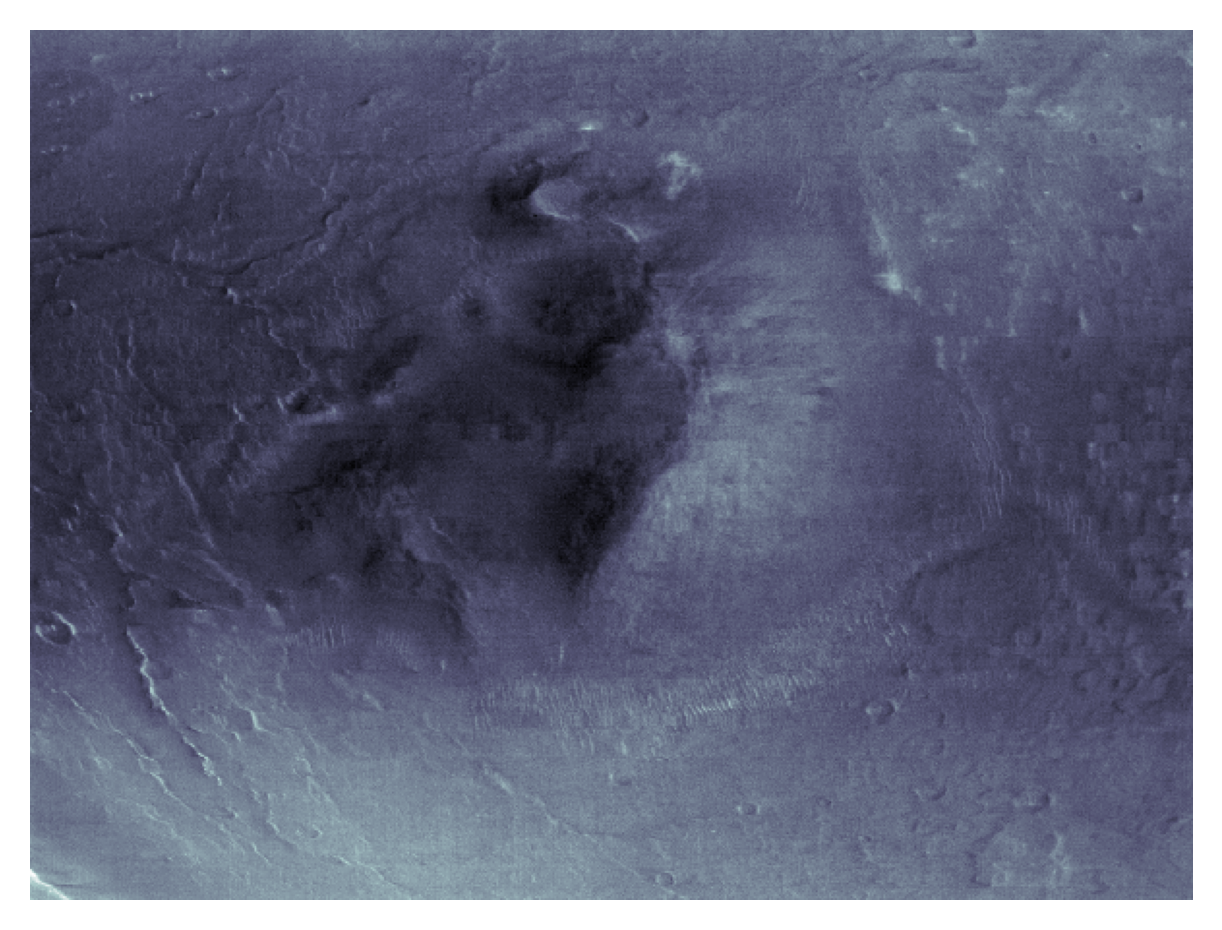

In [30]:
from spectral import imshow
from utils.plotting import *
bands = (10, 20, 50)
imshow(data=s_img, bands=bands)

imshow(data=l_img, bands=bands)

with open(DATA_DIR + "PREPROCESSED_DATA/CRISM/" + img_save_name + '.pickle', 'rb') as handle:
    img = pickle.load(handle)
plot_CRISM_img(img, DATA_DIR + "PREPROCESSED_DATA/CRISM/" + "frt00010628.pdf")